# Approach 2: Background estimation
For this approach, we consider a time series of motion (and lapse) images, i.e. all images in the serious are close together in time (here +- 10 min).

We extract the median image by taking the median of every pixel over all images in the series. Then, for every image the squared pixel-wise difference to the median image is computed. As in the previous approach, we assume that anomalous images highly differ from the median image.

The median image is used as a (possibly more accurate) approximation of the background instead of the closest lapse image.

### Advantages compared to approach 1a
- more resistent to noise
- more resistent to small object movements
- only sensitive to camera movement within the time series

### Problems
- still no color information
- the lighting difference within the series are still a problem

In [22]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy import ndimage
from sklearn.linear_model import LogisticRegression

from py.PlotUtils import plot_roc_curve, get_percentiles
from py.Dataset import Dataset
from py.ImageUtils import display_images
from py.Labels import LABELS

DIR = './ResizedSessions_NoBackup' # dataset directory

ds = Dataset(DIR)
session = ds.create_session("gfox_03")
append_lapse_image = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 3 sessions
Session 'GFox_03' at folder: ./ResizedSessions_NoBackup/VIELAAS_Spring_Session03-VIELAAS_GFox_03
Loaded scans.


In [23]:
img_set = session.get_random_motion_image_set(day_only=True)
if append_lapse_image:
    before, after, rel = img_set[0].get_closest_lapse_images()
    if rel < 0.15 and before is not None:
        img_set.append(before)
    if rel > 0.85 and after is not None:
        img_set.append(after)
print(f"{len(img_set)} images in set")

Generating motion map...
45 images in set


In [24]:
# Read all images
imgs = []
for img in tqdm(img_set):
    arr = img.read(gray=True)
    # normalize
    # arr = (arr - np.mean(arr)) / np.std(arr)
    imgs.append(arr)
imgs = np.array(imgs)

  0%|          | 0/45 [00:00<?, ?it/s]

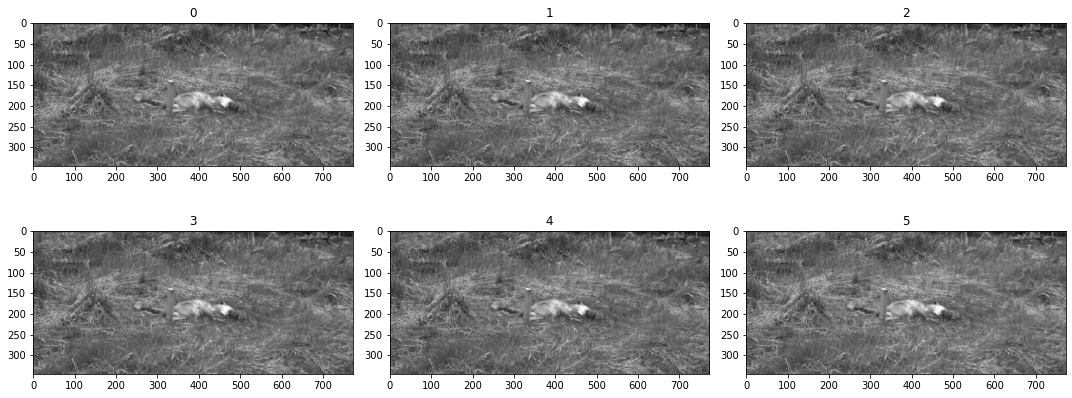

In [25]:
display_images(imgs[:6], list(range(len(imgs)))[:12], row_size=3, size=(5, 3), cmap="gray", vmin=0, vmax=1)

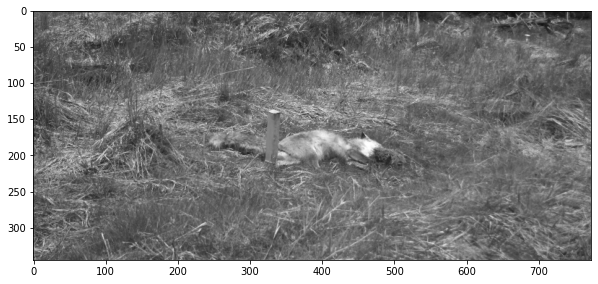

In [26]:
# Find median image
median = np.median(imgs, axis=0)
plt.figure(figsize=(10, 8))
plt.imshow(median, cmap="gray", vmin=0, vmax=1)

In [27]:
diffs = abs(imgs - median)

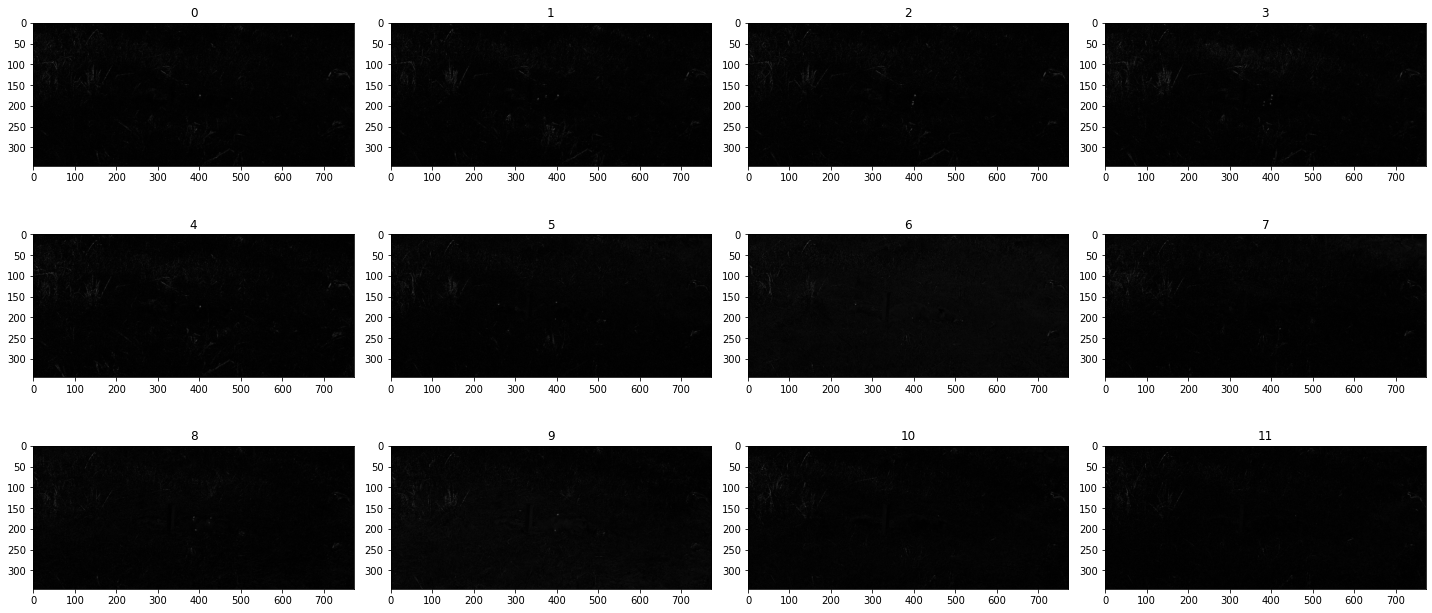

In [28]:
display_images(diffs[:12], list(range(len(diffs)))[:12], row_size=4, size=(5, 3), cmap="gray", vmin=0, vmax=1)

## Complete test

In [ ]:
results = []

with tqdm(total=len(session.motion_dates)) as pbar:
    for img_set in session.generate_motion_image_sets():
        # Optionally append a close lapse image
        if append_lapse_image:
            before, after, rel = img_set[0].get_closest_lapse_images()
            if rel < 0.15 and before is not None:
                img_set.append(before)
            if rel > 0.85 and after is not None:
                img_set.append(after)
            print(f"{len(img_set)} images in set")
        
        # Read all images
        imgs = []
        for img in img_set:
            arr = img.read(gray=True)
            # normalize
            # arr = (arr - np.mean(arr)) / np.std(arr)
            imgs.append(arr)
            pbar.update(1)
        imgs = np.array(imgs)

        # Find median image, calculate diffs
        median = np.median(imgs, axis=0)
        diffs = (imgs - median) ** 2
        means = np.mean(diffs, axis=(1,2))
        vars = np.var(diffs, axis=(1,2))
        for img, mean, var in zip(img_set, means, vars):
            results.append([img.filename, mean, var])

### Save and load results

In [12]:
np.save(f"Cache_NoBackup/approach2_{session.name}_results.npy", results)

In [11]:
results = np.load(f"Cache_NoBackup/approach2_{session.name}_results.npy")
results

array([['Beaver_01_00001.jpg', '0.03157315058171535',
        '0.008842501879227922'],
       ['Beaver_01_00002.jpg', '0.01590260488964755',
        '0.004257656931850018'],
       ['Beaver_01_00003.jpg', '0.005390408061453107',
        '0.00032305310691840193'],
       ...,
       ['Beaver_01_00693.jpg', '0.06754646257597216',
        '0.012471854739153881'],
       ['Beaver_01_00694.jpg', '0.055833027874570236',
        '0.008597549614760561'],
       ['Beaver_01_00695.jpg', '0.07819557309669879',
        '0.009699179824057685']], dtype='<U22')

### Visualize datapoints

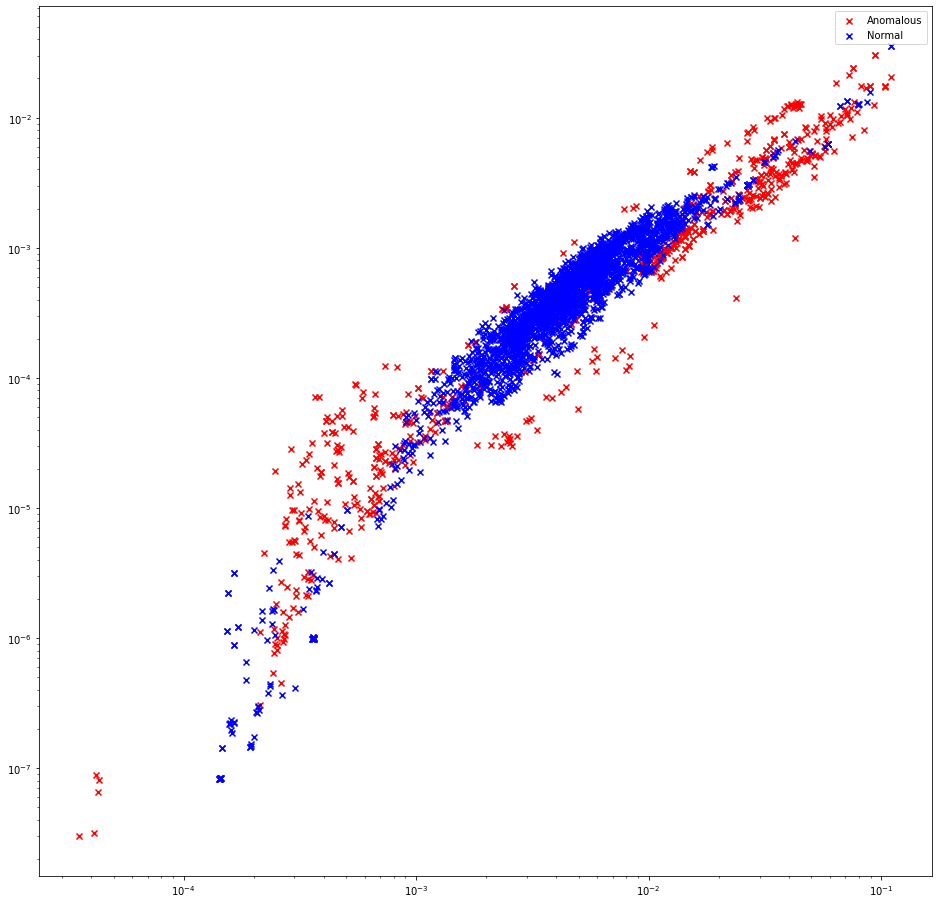

In [13]:
normal = []
anomalous = []
motion_only_session = (session.name[0] == "G")
for filename, mean, var in results:
    vals = [float(mean), float(var)]
    if not filename.startswith("20"):
        # motion img, check label
        img_nr = int(filename[-9:-4])
        if img_nr in LABELS[session.name]["normal"]:
            normal.append(vals)
        elif img_nr not in LABELS[session.name]["not_annotated"]:
            anomalous.append(vals)
    else:
        # lapse image, always normal
        assert not motion_only_session
        normal.append(vals)
normal = np.array(normal)
anomalous = np.array(anomalous)

plt.figure(figsize=(16,16))
plt.scatter(anomalous[:,0], anomalous[:,1], label="Anomalous", color="red", marker="x")
plt.scatter(normal[:,0], normal[:,1], label="Normal", color="blue", marker="x")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

### Thresholding & Scores

In [14]:
y_anom = anomalous
assert y_anom.shape[1] == 2

y_norm = normal
assert y_norm.shape[1] == 2

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(3105, 2)
(3105,)


sqmean auc = 0.6018951247987953
0.9 percentile : TPR = 0.9057, FPR = 0.9684 <-> TNR = 0.0316 @ thresh 0.0003758795016096645
0.95 percentile : TPR = 0.9727, FPR = 0.9764 <-> TNR = 0.0236 @ thresh 0.0002671284369219634
0.98 percentile : TPR = 0.9850, FPR = 0.9772 <-> TNR = 0.0228 @ thresh 0.0002464688812231967
0.99 percentile : TPR = 0.9904, FPR = 0.9819 <-> TNR = 0.0181 @ thresh 0.0002225624735737834
sqvar auc = 0.5664796239110761
0.9 percentile : TPR = 0.9003, FPR = 0.9633 <-> TNR = 0.0367 @ thresh 9.54648154742993e-06
0.95 percentile : TPR = 0.9508, FPR = 0.9684 <-> TNR = 0.0316 @ thresh 3.238179320252646e-06
0.98 percentile : TPR = 0.9809, FPR = 0.9815 <-> TNR = 0.0185 @ thresh 9.98492551834797e-07
0.99 percentile : TPR = 0.9904, FPR = 0.9857 <-> TNR = 0.0143 @ thresh 5.41580910027951e-07


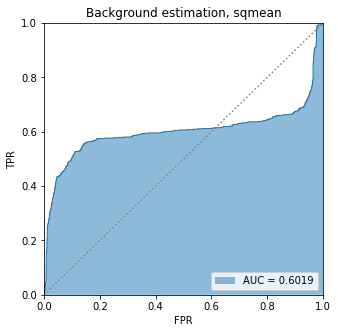

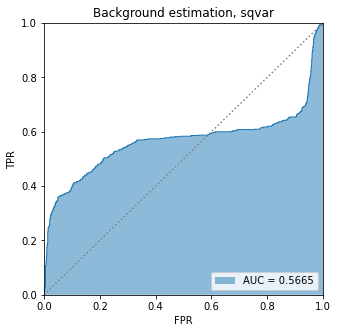

In [15]:
vals = ["sqmean", "sqvar"]
for i in range(2):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Background estimation, {vals[i]}", savefile=f"plots/approach2/roc_curves/{session.name}_{vals[i]}", show=False, figsize=(5,5))
    print(f"{vals[i]} auc = {auc_score}")
    get_percentiles(fpr, tpr, thresholds)

## Experiment 2: Add Gaussian filter
Two orders possible:
- 1. Gaussian filter images, 2. Calculate median image
- 1. Calculate median image, 2. Gaussian filter images + median image

Experiments show that order 1 yields better results.

In [29]:
sigma = 4

In [30]:
results = []

with tqdm(total=len(session.motion_dates)) as pbar:
    for img_set in session.generate_motion_image_sets():
        # Optionally append a close lapse image
        if append_lapse_image:
            before, after, rel = img_set[0].get_closest_lapse_images()
            if rel < 0.15 and before is not None:
                img_set.append(before)
            if rel > 0.85 and after is not None:
                img_set.append(after)
            print(f"{len(img_set)} images in set")
        
        # Read all images
        imgs = []
        for img in img_set:
            arr = img.read(gray=True)
            # normalize
            # arr = (arr - np.mean(arr)) / np.std(arr)
            imgs.append(arr)
            pbar.update(1)
        imgs = np.array(imgs)

        # filter images
        for i in range(len(imgs)):
            imgs[i] = ndimage.gaussian_filter(imgs[i], sigma=sigma)

        # Find median image
        median = np.median(imgs, axis=0)

        # calculate diffs
        diffs = (imgs - median) ** 2
        means = np.mean(diffs, axis=(1,2))
        vars = np.var(diffs, axis=(1,2))
        for img, mean, var in zip(img_set, means, vars):
            results.append([img.filename, mean, var])

  0%|          | 0/4285 [00:00<?, ?it/s]

### Save and load results

In [31]:
np.save(f"Cache_NoBackup/approach2_{session.name}_sigma{sigma}_results.npy", results)

In [ ]:
results = np.load(f"Cache_NoBackup/approach2_{session.name}_sigma{sigma}_results.npy")
results

array([['Beaver_01_00001.jpg', '0.01584533247488625',
        '0.0026823466841092818'],
       ['Beaver_01_00002.jpg', '0.008824170959448192',
        '0.0010263360919268011'],
       ['Beaver_01_00003.jpg', '0.0013506161474556024',
        '5.737223796775002e-05'],
       ...,
       ['Beaver_01_00693.jpg', '0.04884697176797362',
        '0.007907754301799172'],
       ['Beaver_01_00694.jpg', '0.037500496727618925',
        '0.004932861765486779'],
       ['Beaver_01_00695.jpg', '0.06166672730106219',
        '0.004550548160890873']], dtype='<U22')

### Visualize datapoints

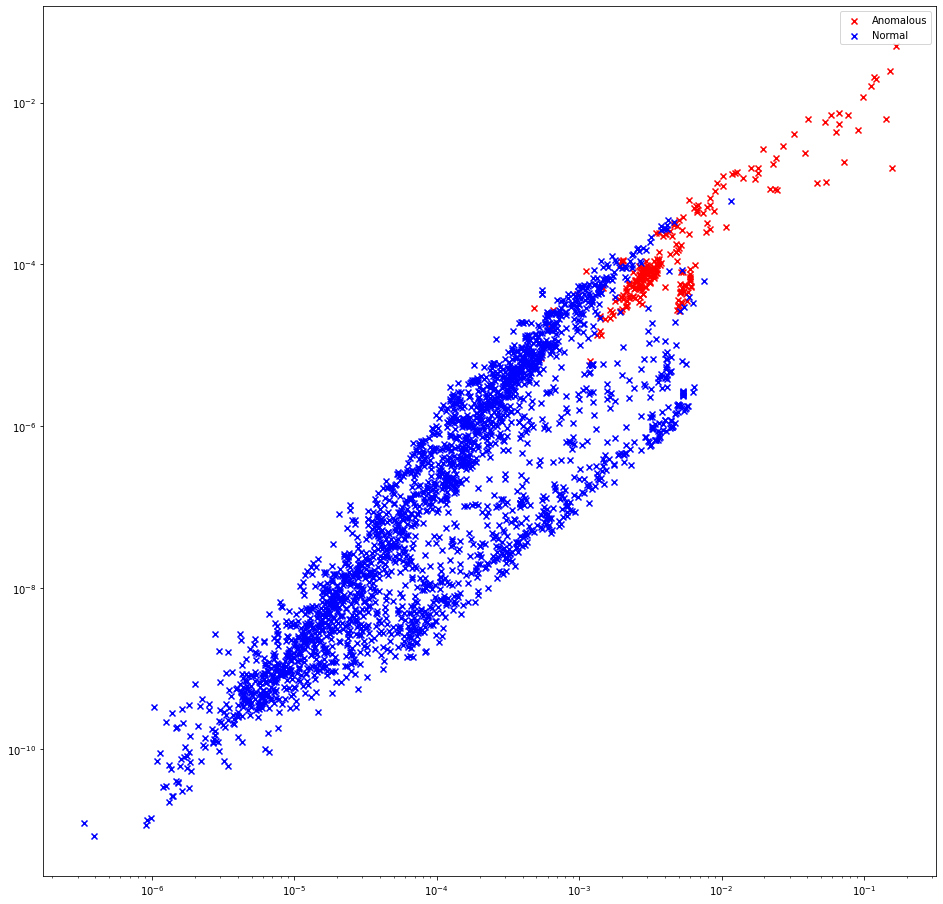

In [35]:
normal = []
anomalous = []
motion_only_session = (session.name[0] == "G")
for filename, mean, var in results:
    vals = [float(mean), float(var)]
    if not filename.startswith("20"):
        # motion img, check label
        img_nr = int(filename[-9:-4])
        if img_nr in LABELS[session.name]["normal"]:
            normal.append(vals)
        elif img_nr not in LABELS[session.name]["not_annotated"]:
            anomalous.append(vals)
    else:
        # lapse image, always normal
        assert not motion_only_session
        normal.append(vals)
normal = np.array(normal)
anomalous = np.array(anomalous)

plt.figure(figsize=(16,16))
plt.scatter(anomalous[:,0], anomalous[:,1], label="Anomalous", color="red", marker="x")
plt.scatter(normal[:,0], normal[:,1], label="Normal", color="blue", marker="x")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

### Thresholding & Scores

In [36]:
y_anom = anomalous
assert y_anom.shape[1] == 2

y_norm = normal
assert y_norm.shape[1] == 2

X = np.concatenate([y_norm, y_anom])
print(X.shape)
y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
print(y.shape)

(2738, 2)
(2738,)


sqmean auc = 0.9660719179422934
0.9 percentile : TPR = 0.9024, FPR = 0.0630 <-> TNR = 0.9370 @ thresh 0.0019918023103186093
0.95 percentile : TPR = 0.9512, FPR = 0.0770 <-> TNR = 0.9230 @ thresh 0.0015200018108547971
0.98 percentile : TPR = 0.9837, FPR = 0.1236 <-> TNR = 0.8764 @ thresh 0.0009584579791728374
0.99 percentile : TPR = 0.9919, FPR = 0.1693 <-> TNR = 0.8307 @ thresh 0.0006298934033365306
sqvar auc = 0.9812065275548422
0.9 percentile : TPR = 0.9024, FPR = 0.0445 <-> TNR = 0.9555 @ thresh 3.187573137314759e-05
0.95 percentile : TPR = 0.9512, FPR = 0.0490 <-> TNR = 0.9510 @ thresh 2.6650384273320288e-05
0.98 percentile : TPR = 0.9837, FPR = 0.0783 <-> TNR = 0.9217 @ thresh 1.4823147816135393e-05
0.99 percentile : TPR = 0.9919, FPR = 0.0827 <-> TNR = 0.9173 @ thresh 1.3226769228072742e-05


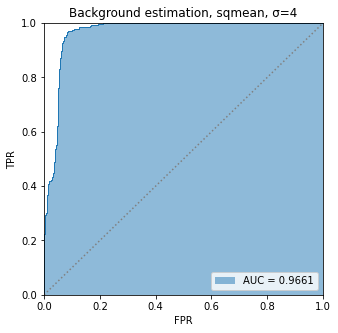

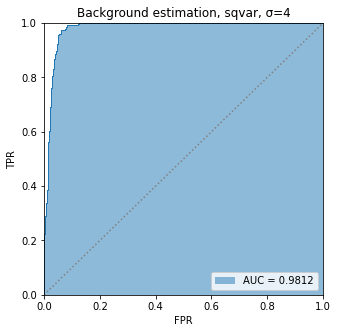

In [37]:
vals = ["sqmean", "sqvar"]
for i in range(2):
    fpr, tpr, thresholds, auc_score = plot_roc_curve(y, X[:,i], f"Background estimation, {vals[i]}, σ={sigma}", savefile=f"plots/approach2/roc_curves/{session.name}_{vals[i]}_sigma{sigma}", show=False, figsize=(5,5))
    print(f"{vals[i]} auc = {auc_score}")
    get_percentiles(fpr, tpr, thresholds)